In [189]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

### d = f(x,a,b) + n, f a non-linear function, x and n Gaussian variables

In [166]:
def f(x,thetas):
    np.random.seed(35)
    A = np.random.randint(low=1, high=6, size=[x.shape[-1]-1,x.shape[-1]])
    print(A)
    y = np.einsum('jk,ik->ij',A,x)
    return thetas[0]*y+thetas[1]*y**2

Noise level

In [196]:
# data dimensionality
data_dim   = 2
sig_dim    = 3
# noise level
sigma = 2
# model parameters
theta_true = [2,0.1]
theta_fid  = [1.5,0.2]

In [197]:
def generate_noise(sigma,dim=1,nsamples=100,rand_seed=None):
    np.random.seed(rand_seed)
    noise = np.random.randn(nsamples,dim)*sigma
    return noise

In [198]:
def generate_signal(dim=1, nsamples=100,rand_seed=None):
    
    np.random.seed(rand_seed)
    x      = np.random.randn(nsamples,dim)
    
    return x

In [199]:
def generate_data(thetas,sigma,sig_dim,data_dim,nsamples,rand_seed=None):
    
    x      = generate_signal(sig_dim,nsamples,rand_seed)
    noise  = generate_noise(sigma,data_dim,nsamples,rand_seed)
    data   = f(x,thetas)+noise
    
    return data

In [200]:
true_data = generate_data(theta_true,sigma,sig_dim=sig_dim, data_dim=data_dim, nsamples=1,rand_seed=902)
fid_data  = generate_data(theta_fid,sigma,sig_dim=sig_dim, data_dim=data_dim, nsamples=10000,rand_seed=104)

[[2 5 2]
 [5 1 2]]
[[2 5 2]
 [5 1 2]]


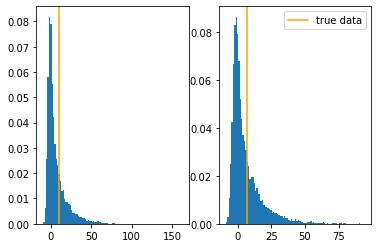

In [201]:
plt.title('data histogram')
for ii in range(data_dim):
    plt.subplot(1,data_dim,ii+1)
    _, bins,_ = plt.hist(fid_data[:,ii], density=True,bins=100)
    plt.axvline(true_data[:,ii], c='orange', label='true data')
plt.legend()
plt.show()

In [202]:
def estimate_covariance(data):
    mean = np.mean(data)
    cov  = np.dot((data-mean).T,(data-mean))
    return cov/(len(data)-1)

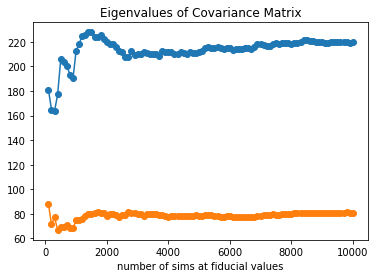

In [206]:
n_splits = 100
split_data = np.split(fid_data,n_splits)
data_chunk = split_data[0]
covs = [estimate_covariance(data_chunk)]
for ii in range(n_splits-1):
    ii+=1
    data_chunk=np.concatenate((data_chunk,split_data[ii]),axis=0)
    covs.append(estimate_covariance(data_chunk))
covs= np.asarray(covs)
eigvals = np.linalg.eigvals(covs)

plt.title('Eigenvalues of Covariance Matrix')
for ii in range(2):
    plt.plot((np.arange(n_splits)+1)*(len(fid_data)//n_splits),eigvals[:,ii], marker='o')
plt.xlabel('number of sims at fiducial values')
plt.show()

cov = estimate_covariance(fid_data)

In [207]:
def get_Gaussian(mu,Sigma):
    
    def Gaussian(x):
        return 1/np.sqrt((2.*np.pi))/Sigma*np.exp(-0.5*(x-mu)**2/Sigma**2)
    
    return Gaussian

#Gaussian estimation of fiducial P(d|theta):
likelihood = get_Gaussian(true_data,cov)
prior      = get_Gaussian(theta_fid,np.array([[3,0],[0,3]]))


def joint_distribution(thetas,rand_seed):
    fwd = generate_data(thetas,sigma,sig_dim=sig_dim, data_dim=data_dim, nsamples=1,rand_seed=rand_seed)
    return likelihood(fwd)+prior(thetas)

#### Fit P(A|d) by Fisher Analysis

In [104]:
def get_Sigma(params):
    a,b = params
    return a**2+1

def get_mu(params):
    a,b = params
    return (b-2)**2

In [105]:
def data_probability(params,data):
    Sigma = get_Sigma(params)
    mu    = get_mu(params)
    prob  = get_Gaussian(mu, Sigma)
    return prob(data)

In [226]:
def finite_diff(params,func):
    delta_params = np.asarray([0.001,0.001])
    derivative = (func(params+delta_params)-func(params-delta_params))/(2*delta_params)
    return derivative

In [227]:
from functools import partial

In [228]:
def generate_data(params):
    Sigma = get_Sigma(params)
    mu    = get_mu(params)
    data  = Sigma*np.random.randn(1)+mu
    return data

In [229]:
true_params = [1.5,2]

In [310]:
data = generate_data(true_params)
print(data)
#to make it a hard problem, set data to 3.71343085
#data = 3.71343085
# to make it an easy problem, set data to -2.08261133

[-7.65952663]


In [311]:
p_of_params = partial(data_probability, data=data)
deriv       = partial(finite_diff,func=p_of_params)
# if it's not too much work: maybe you can try to replace the finite differencing operator by it's analytical derivative?

In [312]:
from scipy.optimize import fsolve, minimize

In [313]:
params_init = [1.,2.]

In [314]:
# this solver is not working well, as you can see
output= fsolve(deriv,params_init,full_output=True,maxfev=1000,xtol=1e-10)
print(output)
best_params= output[0]
print(best_params)

(array([0.90268926, 9.69388583]), {'nfev': 1000, 'fjac': array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]]), 'r': array([ 3.27416458e-284,  8.04570754e-284, -3.34263791e-304]), 'qtf': array([-1.65748383e-292,  6.67515272e-308]), 'fvec': array([5.68985824e-293, 5.68985824e-293])}, 2, 'The number of calls to function has reached maxfev = 1000.')
[0.90268926 9.69388583]


In [315]:
# here we sample the probability distribution on a grid
# (I think that's what Lister tried to do, or maybe even did?)
a_ = np.linspace(-5,5,100)
b_ = np.linspace(-2,5,100)
a_, b_ = np.meshgrid(a_,b_)
p  = p_of_params([a_,b_])


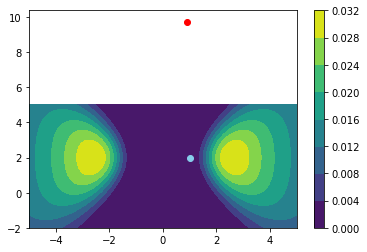

In [316]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
fig.colorbar(cp)

In [317]:
#let's switch to minimization instead. This is the Nelder-Mead algorithm
result = minimize(lambda params: -p_of_params(params),params_init, method='Nelder-Mead')
print(result)
best_params=result['x']

 final_simplex: (array([[2.58062186, 2.00005914],
       [2.58052859, 1.99997961],
       [2.58054624, 2.0000969 ]]), array([-0.03159082, -0.03159082, -0.03159082]))
           fun: -0.03159081963698711
       message: 'Optimization terminated successfully.'
          nfev: 77
           nit: 40
        status: 0
       success: True
             x: array([2.58062186, 2.00005914])


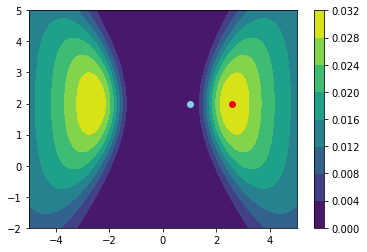

In [318]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
fig.colorbar(cp)
## -> it works very well

In [319]:
#let's try another algorithm
result = minimize(lambda params: -p_of_params(params),params_init, jac=lambda params: -deriv(params), method='L-BFGS-B', options=dict(gtol=1e-40,ftol=1e-40))
print(result)
best_params=result['x']
#it get's stuck 

      fun: array([-0.02163483])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 7
   status: 0
  success: True
        x: array([2.53683109, 3.53683109])


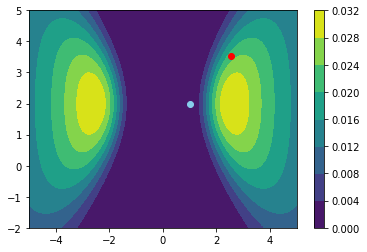

In [320]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
fig.colorbar(cp)

In [321]:
#let's try another algorithm
result = minimize(lambda params: -p_of_params(params),params_init, jac=lambda params: -deriv(params), method='Powell')
print(result)
best_params=result['x']

   direc: array([[0.00000000e+00, 1.00000000e+00],
       [2.44131089e-05, 3.12836529e-16]])
     fun: array(-0.03159082)
 message: 'Optimization terminated successfully.'
    nfev: 79
     nit: 2
  status: 0
 success: True
       x: array([2.58060588, 2.        ])


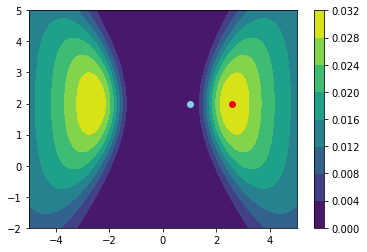

In [322]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
#fig.colorbar(cp)

In [330]:
### explore different starting values
#let's try another algorithm
result = minimize(lambda params: -p_of_params(params),params_init, jac=lambda params: -deriv(params), method='CG')
print(result)
best_params=result['x']

params_init_2=[3,3]
#let's try another algorithm
result = minimize(lambda params: -p_of_params(params),params_init_2, jac=lambda params: -deriv(params), method='CG')
print(result)
best_params2=result['x']
#it get's stuck and tells us so

     fun: array([-0.02101414])
     jac: array([0.0038605, 0.0038605])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 33
     nit: 1
    njev: 21
  status: 2
 success: False
       x: array([2.82366548, 3.82366548])
     fun: -0.03035250312742422
     jac: array([3.3131742e-06, 3.3131742e-06])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 5
    njev: 26
  status: 0
 success: True
       x: array([2.48254563, 2.48254563])


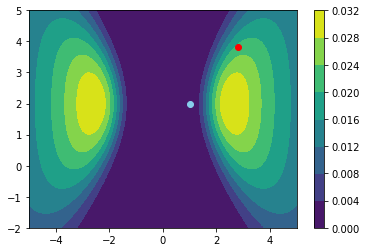

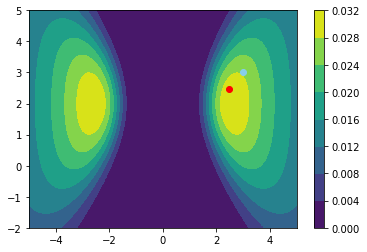

In [333]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
fig.colorbar(cp)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params2[0],best_params2[1],color='red')
plt.scatter(params_init_2[0],params_init_2[1],color='skyblue')
fig.colorbar(cp)

Can you try other algorithms? :) 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
Some of them require a Hessian - you might already have a finite differencing function for Hessians. (See also next question)
Try to find out what these different algorithms do differently.

Can you compute the Fisher information from finite differencing and plot the Gaussian that we get for P(A) from the Fisher analysis?